<a href="https://colab.research.google.com/github/MikeCheek/neural-style-transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from IPython.display import display, clear_output
import ipywidgets as widgets

In [ ]:
output_dir = "intermediate_outputs"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def load_and_process_image(image_path, target_size=(400, 400)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = tf.keras.applications.vgg19.preprocess_input(img)  # Preprocess image for VGG19
    return np.expand_dims(img, axis=0)  # Add batch dimension (batch_size=1)

def deprocess_image(processed_img):
    x = processed_img.copy()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert from BGR to RGB
    return np.clip(x, 0, 255).astype('uint8')  # Clip the values to valid pixel range [0, 255]

# Create a feature extractor model (VGG19)
def get_feature_extractor():
    vgg = VGG19(include_top=False, weights='imagenet')  # Load VGG19 without the top layers
    content_layers = ['block5_conv2']  # Layer for extracting content features
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  # Layers for extracting style features
    outputs = [vgg.get_layer(name).output for name in content_layers + style_layers]  # Get the outputs of the selected layers
    model = Model(inputs=vgg.input, outputs=outputs)
    model.trainable = False  # Freeze the layers to not update weights during training
    return model, content_layers, style_layers

def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))  # Mean squared error

def style_loss(base_style, target_style):
    gram_base_style = gram_matrix(base_style)  # Compute Gram matrix for base style
    gram_target_style = gram_matrix(target_style)  # Compute Gram matrix for target style
    return tf.reduce_mean(tf.square(gram_base_style - gram_target_style))  # Mean squared error of Gram matrices

def gram_matrix(tensor):
    channels = int(tensor.shape[-1])  # Get the number of channels (filters)
    a = tf.reshape(tensor, [-1, channels])  # Reshape the tensor to a 2D matrix
    n = tf.shape(a)[0]  # Get the number of elements
    gram = tf.matmul(a, a, transpose_a=True)  # Compute the Gram matrix (outer product)
    return gram / tf.cast(n, tf.float32)  # Normalize by the number of elements

def total_variation_loss(image):
    x_deltas = image[:, :-1, :, :] - image[:, 1:, :, :]
    y_deltas = image[:-1, :, :, :] - image[1:, :, :, :]
    return tf.reduce_mean(tf.square(x_deltas)) + tf.reduce_mean(tf.square(y_deltas))

# Compute total loss: content loss + style loss + total variation loss
def compute_loss(model, loss_weights, init_image, content_features, style_features, content_layers, style_layers):
    input_tensor = tf.concat([init_image], axis=0)  # Combine the input image into a batch
    outputs = model(input_tensor)
    content_outputs = outputs[:len(content_layers)]
    style_outputs = outputs[len(content_layers):]

    content_loss_value = 0
    style_loss_value = 0

    weight_content, weight_style, weight_tv = loss_weights  # Unpack the loss weights

    # Calculate content loss for each content layer
    for content, target in zip(content_outputs, content_features):
        content_loss_value += content_loss(content, target)

    # Calculate style loss for each style layer
    for style, target in zip(style_outputs, style_features):
        style_loss_value += style_loss(style, target)

    # Calculate total variation loss
    tv_loss_value = total_variation_loss(init_image)

    # Total loss is a weighted sum of content, style, and TV losses
    total_loss = weight_content * content_loss_value + weight_style * style_loss_value + weight_tv * tv_loss_value
    return total_loss

def create_gif(image_dir, gif_path, duration=200):
    images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
    images.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))  # Sort by iteration number

    frames = [Image.open(img) for img in images]
    frames[0].save(gif_path, save_all=True, append_images=frames[1:], loop=0, duration=duration)
    print(f"GIF saved to {gif_path}")

In [ ]:
def style_transfer(content_path, style_path, iterations=1000, content_weight=1e3, style_weight=1e-2, tv_weight=1e-4, save_interval=100):
    content_image = load_and_process_image(content_path)
    style_image = load_and_process_image(style_path)
    init_image = tf.Variable(content_image, dtype=tf.float32)  # Initialize the image as a variable

    model, content_layers, style_layers = get_feature_extractor()  # Get the VGG19 model and selected layers

    content_outputs = model(content_image)
    style_outputs = model(style_image)
    content_features = [content_outputs[i] for i in range(len(content_layers))]
    style_features = [style_outputs[i] for i in range(len(content_layers), len(content_layers) + len(style_layers))]

    # Learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=5.0,
        decay_steps=100,
        decay_rate=0.96
    )
    opt = tf.optimizers.Adam(learning_rate=lr_schedule)
    loss_weights = (content_weight, style_weight, tv_weight)  # Set the loss weights for content, style, and TV

    @tf.function
    def train_step(image):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, loss_weights, image, content_features, style_features, content_layers, style_layers)
        grad = tape.gradient(loss, image)  # Compute gradients of the loss with respect to the image
        opt.apply_gradients([(grad, image)])  # Apply gradients to the image
        image.assign(tf.clip_by_value(image, -103.939, 255.0 - 103.939))  # Clip image to valid range

    # Create an output widget for live visualization
    out = widgets.Output()
    display(out)

    # Progress bar for training iterations
    for i in tqdm(range(iterations), desc="Style Transfer Progress"):
        train_step(init_image)  # Perform one training step

        # Display intermediate images live
        if i % save_interval == 0 or i == iterations - 1:
            with out:
                clear_output(wait=True)  # Clear the previous output
                intermediate_image = deprocess_image(init_image.numpy()[0])
                plt.imshow(intermediate_image)
                plt.axis('off')
                plt.show()

    # Deprocess the image to get final output
    final_image = deprocess_image(init_image.numpy()[0])
    return final_image

Output()

Style Transfer Progress:  30%|██▉       | 299/1000 [00:20<00:44, 15.66it/s]

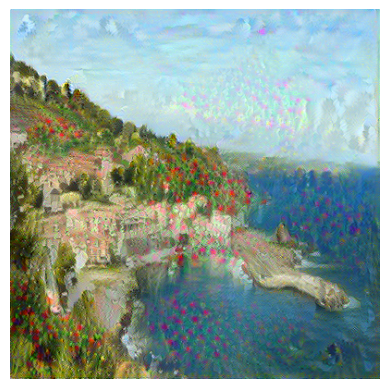

Style Transfer Progress:  60%|█████▉    | 599/1000 [00:40<00:24, 16.08it/s]

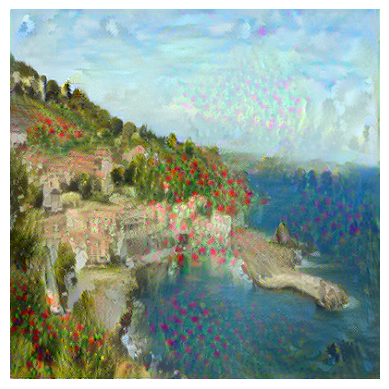

Style Transfer Progress:  79%|███████▊  | 787/1000 [00:51<00:13, 16.16it/s]

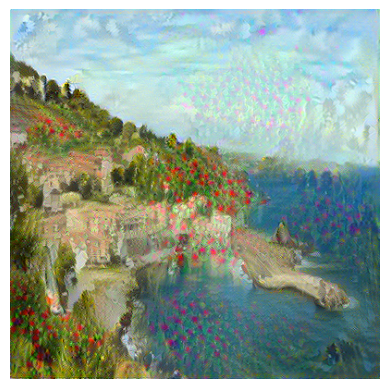

Style Transfer Progress:  90%|█████████ | 900/1000 [00:59<00:06, 16.30it/s]

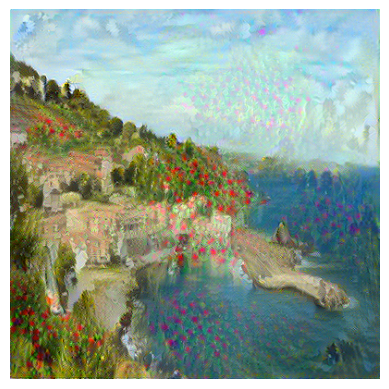

Style Transfer Progress: 100%|█████████▉| 997/1000 [01:05<00:00, 16.36it/s]

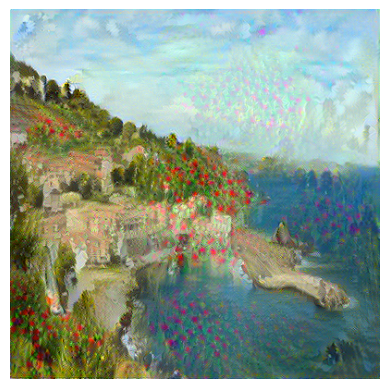

Style Transfer Progress: 100%|██████████| 1000/1000 [01:05<00:00, 15.21it/s]


In [ ]:
content_image_path = "org.jpeg"  # Replace with your content image path
style_image_path = "target.jpg"  # Replace with your style image path

output_image = style_transfer(content_image_path, style_image_path, iterations=1000, save_interval=100)

GIF saved to style_transfer_progress.gif


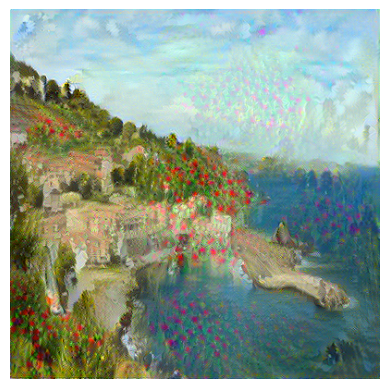

In [ ]:
gif_path = "style_transfer_progress.gif"
create_gif(output_dir, gif_path, duration=200)

# Display the final result
plt.imshow(output_image)
plt.axis('off')
plt.show()